In [545]:
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

import urllib.parse # combine URL components into URL string
import wikipediaapi # query wikipedia through api
import requests # standard for making HTTP requests

from hampel import hampel # hampel filter to detect anomalies
from statsmodels.tsa.seasonal import STL # seasonal decompositions
import statsmodels.tsa.stattools as smt

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

from pytrends.request import TrendReq # google trends

import pickle #  to serialize and deserialize objects in Python

from scipy import signal
import scipy.stats

from datetime import timedelta, date
from iso3166 import countries

from ADA_functions_ import *

import warnings

warnings.filterwarnings("ignore")

## Context

Using Wikipedia pageviews from January 1st 2018 to November 1st 2022, we will investigate the evolution of food habits caused by the COVID-19 pandemic.

The languages provided in the Coronawiki dataset are namely: Italian, English, French, German, Swedish, Norvegian, Danish, Dutch, Korean, Serbian, Turkish, Catalan, Finnish, Japanese. Hereby, we need to consider the issue of certain languages being spoken across multiple countries. For Italian and German, we neglect the contribution of secondary countries (such as Switzerland). With French, there is a bigger problem as it is spoken across 29 countries, so we will exclude French from the dataset as we cannot obtain reliable causal interpretations. Last but not least, given that English is a universal language, we will consider it as representation of the entire world (baseline).

We are creating our dataset by querying the previously defined Wikipedia categories across the Wikipedia languages. This is done by translating the title of the category in the desired language, creating the corresponding URL and eventually querying the category members. However, we encountered translation issues with the following four languages: Swedish, Danish, Norwegian, Japanese and Korean. After further analysis, we figured out that for example the word cuisine (köket) is translated to dish (maträtter) in the Swedish Wikipedia. Therefore, the automatic search did not work and we will have to manually add the categories for these wikipedia languages to the dataset. For this reason, we use the code below only on the "successful" languages.

In [179]:
successful_languages = ['it','en','de','nl','sr','tr','ca', 'fi']

To have the Wikipedia page titles in the 8 successful languages, we use the wiki-api library and translate the category titles starting from the English language. One drawback of using categories is that some of them may exist in some languages but not in others. Similarly, they may contain different pages depending on the language. We will therefore have to deal with some missing data. We are including in our analysis both mobile and computer access, since we want to study culinary habits regardless of which device people prefer to use to do their research. We extend the temporal duration of information acquisition of wikipedia pageviews to the present day. This may help us answer questions regarding whether certain changes due to Covid are still influencing individuals' searches.

To make our analysis less sensitive to single-day peaks, not necessarily correlated with the Covid pandemic, we obtain the weekly average of the pageviews of the different categories. In this regard, considering that the API does not report daily data for all wikipedia pages, we eliminate from our analysis the search titles that do not have complete data. Besides, we know that daily covid cases are more meaningful when averaged over the week since less are counted on Sundays, and more on Mondays to catch up. As we relate the pageviews to Covid cases, it makes sense to use weekly averages for both.

## Research question 1

### Context

We first investigate the change in interest for healthy or unhealthy food during the Covid-19 pandemic. 

Particularly during the lockdown, food has been a common way to occupy minds and hands for people around the world. As such, food makes us come together, but it can also highlight crucial cultural differences. For example, the preference for healthy or less healthy food at a time of crisis can show great disparities between different cultures. Some people may indeed be using carbohydrates to cope with stress and boredom, while others might have taken their extended period of time at home as an opportunity to improve their diets. They might have had more time to cook and to do research on recipes and dietetics, and discovered new dishes they like. Furthermore, the usage of food delivery apps blew up and was normalized in many households, making new types of food accessible. All these elements are connected to a language community's culture and political environment during the pandemic.

For this part of the project, we thus focus our analysis of food behavior across cultures on the interest shift for healthy or unhealthy foods during the pandemic. We are curious about the type of nutrition that received more attention in reaction to important changes in people's daily lives.

### Creating the healthy and unhealthy food pageview datasets

We defined 2 lists of Wikipedia categories, one related to healthy food and one related to unhealthy food. In order to choose the categories to include, we looked through the literature on NLP for the analysis of healthy food consumption. A recent study using Tweets to characterize healthy food prevalence in the US provided a list of keywords for healthy and unhealthy food [[1](https://www.sciencedirect.com/science/article/pii/S0143622814001775)]. We got inspiration from their keywords to find our categories. As in that study, we excluded grains, protein foods and dairy from the healthy categories as they are only healthy as long as they are not consumed in large quantities. On top of food, we added some categories related to drinks as we include them in a more global definition of consumption.

In [6]:
healthy_categories = ["Edible_plants", "Fruit_dishes", "Vegetable_dishes", "Tea", "Nutrition_guides", "Dietetics", "Drinking_water"]
unhealthy_categories = ["Fast_food", "Charcuterie", "Cheese", "Cakes", "Candy", "Sausages", "Cookies", "Doughnuts", "Hot_dogs", "Energy_drinks", "Ice_cream", "Pastries", "Pizza", "Soft_drinks", "Sports_drinks", "Fast-food_restaurants", "Alcoholic_drinks"]

We represent the number of pages in the English version of these categories in the following pie charts.

In [551]:
# Pie chart of the number of pages in each healthy category
healthy_pg_n = []
for cat in healthy_categories:
    healthy_pg_n.append({'Category': cat.replace('_', ' '), 'Count': count_pages_en(cat)})
healthy_count = pd.DataFrame(healthy_pg_n)


fig = px.pie(healthy_count, values='Count', names='Category', color_discrete_sequence=px.colors.sequential.Blugrn)
fig.update_layout(
    title={
        'text': 'Number of pages in each category of healthy food',
        'y':0.95,
        'x':0.475,
        'xanchor': 'center',
        'yanchor': 'top'})
pio.write_html(fig,"healthy_pie.html")
fig.show()

In [552]:
# Pie chart of the number of pages in each unhealthy category
unhealthy_pg_n = []
for cat in unhealthy_categories:
    unhealthy_pg_n.append({'Category': cat.replace('_', ' '), 'Count': count_pages_en(cat)})
unhealthy_count = pd.DataFrame(unhealthy_pg_n)

fig = px.pie(unhealthy_count, values='Count', names='Category', color_discrete_sequence=px.colors.sequential.Oryel)
fig.update_layout(
    title={
        'text': 'Number of pages in each category of unhealthy food',
        'y':0.95,
        'x':0.45,
        'xanchor': 'center',
        'yanchor': 'top'})
pio.write_html(fig,"unhealthy_pie.html")
fig.show()

We create dataframes with view counts for the healthy and unhealthy categories in Italian and save them for later use.
For the English language, we sum the view counts of the pages in each category. For the other languages, we extract the page titles for each category in English and translate them to the desired language, instead of translating the category. We then sum the view counts of the translated pages. Using the pages contained in the English categories allowed us to keep more data than directly translating the categories, as some of them did not exist in some languages.

In [ ]:
# Creating dataframes and saving them to csv files
for lan in successful_languages:
    pageviews1 = create_dataframe_language(healthy_categories, lan)
    pageviews1.to_csv('healthy_pageviews_'+lan+'.csv', index=False)
    pageviews2 = create_dataframe_language(unhealthy_categories, lan)
    pageviews2.to_csv('unhealthy_pageviews_'+lan+'.csv', index=False)

Given that the above cell takes a long time to run, we exported the results to csv sheets. The code below loads the datasets from the csv files.

In [7]:
# Loading the dataframes for healthy and unhealthy food categories, converting the dates to the right format
healthy_pageviews = {}
unhealthy_pageviews = {}
for lan in successful_languages:
    healthy_pageviews[lan] = pd.read_csv(r'./dataframes/true_healthy_pageviews_'+lan+'.csv')
    healthy_pageviews[lan]['date'] = pd.to_datetime(healthy_pageviews[lan].date, format='%Y-%m-%d')
    healthy_pageviews[lan].insert(0, 'date', healthy_pageviews[lan].pop('date'))
    unhealthy_pageviews[lan] = pd.read_csv(r'./dataframes/true_unhealthy_pageviews_'+lan+'.csv')
    unhealthy_pageviews[lan]['date'] = pd.to_datetime(unhealthy_pageviews[lan].date, format='%Y-%m-%d')
    unhealthy_pageviews[lan].insert(0, 'date', unhealthy_pageviews[lan].pop('date'))

### Loading the mobility data

Now we load the mobility data, which we will use to find how the interest for healthier food can relate to the mobility restrictions during the pandemic.

In [506]:
# creating the isocode2 version of the succesful_languages, necessary to access the different countries in the Google Mobility data
successful_languages[1] = 'us'
isocode2 = [countries.get(lan).alpha2 for lan in successful_languages]
isocode2[4] = 'RS'
successful_languages[1] = 'en'
isocode2

['IT', 'US', 'DE', 'NL', 'RS', 'TR', 'CA', 'FI']

In [530]:
# Loading mobility data
mob_data = pd.read_csv('./data/Global_Mobility_Report.csv')
mob_data['date'] = pd.to_datetime(mob_data['date'])

# preprocess mobility data (mean across the same date, take the weekly data, divide in a dict of different languages/countries)
mob_data_lan = {successful_languages[num]: mob_data[mob_data['country_region_code'] == iso].groupby('date', as_index = False).mean()[::7] for num,iso in enumerate(isocode2)}

In [531]:
# Printing the missing data
mob_data_lan['sr'].iloc[12:15]

,date,census_fips_code,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
84,2020-05-09,NaN,-29.0,-17.5,17.5,-36.5,-23.5,1.5
91,2020-05-16,NaN,-23.0,-14.5,8.5,-27.5,-19.5,0.5
98,2020-07-07,NaN,-6.0,12.5,27.5,-22.0,-33.5,6.0


The values for some weeks are missing for Serbia, between May 16 and July 7 of 2020. We decide to handle this missing data by adding values in the column that we use, `retail_and_recreation_percent_change_from_baseline`, with linear interpolation. The interpolation is based on the values right before and right after.

In [532]:
# We fill the missing weeks with linear interpolation
mob_data_lan['sr']['residential_percent_change_from_baseline'] = mob_data_lan['sr']['residential_percent_change_from_baseline'].astype(float)
for i in range(7):
    keys = mob_data_lan['sr'].keys()
    values = [np.nan for j in range(len(mob_data_lan['sr'].keys()))]
    values[0] = mob_data_lan['sr'].iloc[13]['date'] + timedelta(days=7*(i+1))
    new_row = dict(zip(keys,values))
    mob_data_lan['sr'].loc[92+i*0.1] = values
mob_data_lan['sr']= mob_data_lan['sr'].sort_values(by=['date'])
mob_data_lan['sr'] = mob_data_lan['sr'].replace(pd.NaT, np.nan)    

mob_data_lan['sr']['residential_percent_change_from_baseline'] = mob_data_lan['sr']['residential_percent_change_from_baseline'].interpolate(method ='linear', limit_direction ='forward', axis=0)
mob_data_lan['sr']['date'][15:] = mob_data_lan['sr']['date'][15:] - timedelta(days=3)

### Loading the interventions dataset

We then load the interventions dataset, which contains the dates of important events of the pandemic. We use it to contextualize our data.

In [ ]:
# Loading dataset with intervention dates
interventions = load_interventions()

# Adding some missing dates based on information online
interventions['tr'] = {'Mobility': pd.to_datetime('2020-03-17 00:00:00')}
interventions['tr']['Normalcy'] =  pd.to_datetime(['2020-05-17 00:00:00'])[0]
interventions['en']['Normalcy'] = pd.to_datetime(['2020-07-04'])[0]
interventions['en']['Mobility'] = pd.to_datetime(['2020-03-20'])[0]
interventions['ca']['Normalcy'] = pd.to_datetime(['2020-05-21'])[0]
interventions['sr']['Normalcy'] = pd.to_datetime(['2020-05-17'])[0]

In [ ]:
# Creating the second normalcy data in the interventions based on the maximum value in the mobility data in the year 2021-01-01 00:00:00/2022-01-01 00:00:00

for lan in successful_languages:
    max_ = max(mob_data_lan[lan]['retail_and_recreation_percent_change_from_baseline'][(mob_data_lan[lan]['date']> '2021-01-01') & (mob_data_lan[lan]['date']< '2022-01-01')])
    interventions[lan]['Second_Normalcy'] = pd.to_datetime(mob_data_lan[lan][mob_data_lan[lan]['retail_and_recreation_percent_change_from_baseline'] == max_]['date'].values)[0]

### Preprocessing of food pageviews

We remove the outliers as we want to avoid keeping a very sudden and very high increase in the page view count. We indeed interpret this as the result of some short trend, a recipe going viral, or a similar phenomenon. This timescale is too short for such a strong change and it could bias our data as it does not reflect the evolution of the interest and behavior of a large group of people over time.

In [8]:
# Removing outliers

for lan in successful_languages:
    for food in healthy_categories:
        healthy_pageviews[lan][food] = remove_outliers2(healthy_pageviews, lan, food, 10, 10)
    for food in unhealthy_categories:
        unhealthy_pageviews[lan][food] = remove_outliers2(unhealthy_pageviews, lan, food, 10, 10)

We then perform a z-score standardization on the weekly pageviews of each of our Wikipedia categories using the pageviews of that same category during the corresponding month of 2019: we subtract from our weekly view counts the mean view counts of the same month of 2019 and divide them with the standard deviation of the 2019 pageviews during that month. 

In [9]:
# Making 2 dictionaries to separate 2019 from covid
healthy_2019 = {}
unhealthy_2019 = {}
healthy_covid = {}
unhealthy_covid = {}
for lan in successful_languages:
    healthy_2019[lan] = healthy_pageviews[lan][healthy_pageviews[lan]['date'].dt.year == 2019]
    unhealthy_2019[lan] = unhealthy_pageviews[lan][unhealthy_pageviews[lan]['date'].dt.year == 2019]
    healthy_2019[lan]['month'] = healthy_2019[lan]['date'].dt.month
    unhealthy_2019[lan]['month'] = unhealthy_2019[lan]['date'].dt.month
    healthy_covid[lan] = healthy_pageviews[lan][healthy_pageviews[lan]['date'].dt.year > 2019]
    unhealthy_covid[lan] = unhealthy_pageviews[lan][unhealthy_pageviews[lan]['date'].dt.year > 2019]
    healthy_covid[lan]['month'] = healthy_covid[lan]['date'].dt.month
    unhealthy_covid[lan]['month'] = unhealthy_covid[lan]['date'].dt.month

In [10]:
# Extracting the monthly mean and standard deviation from 2019
healthy_means = {}
unhealthy_means = {}
healthy_stds = {}
unhealthy_stds = {}
for lan in successful_languages:
    healthy_means[lan] = healthy_2019[lan].groupby('month').mean(numeric_only=True)
    unhealthy_means[lan] = unhealthy_2019[lan].groupby('month').mean(numeric_only=True)
    healthy_stds[lan] = healthy_2019[lan].groupby('month').std(numeric_only=True)
    unhealthy_stds[lan] = unhealthy_2019[lan].groupby('month').std(numeric_only=True)

In [12]:
# z-score standardization with the data from the corresponding month of 2019
z_healthy = {} 
z_unhealthy = {}
for lan in successful_languages:
    z_healthy[lan] = pd.DataFrame(z_score(healthy_covid[lan].iloc[0], lan, 1, healthy_covid[lan].iloc[0]['month'], healthy_categories), index=[0])
    z_unhealthy[lan] = pd.DataFrame(z_score(unhealthy_covid[lan].iloc[0], lan, 0, unhealthy_covid[lan].iloc[0]['month'], unhealthy_categories), index=[0])
    for index, row in healthy_covid[lan].iloc[1:].iterrows():
        z_healthy[lan] = z_healthy[lan].append(z_score(row, lan, 1, row['month'], healthy_categories), ignore_index=True)
    for index, row in unhealthy_covid[lan].iloc[1:].iterrows():
        z_unhealthy[lan] = z_unhealthy[lan].append(z_score(row, lan, 0, row['month'], unhealthy_categories), ignore_index=True)
    z_healthy[lan].reset_index()
    z_healthy[lan] = pd.concat([healthy_covid[lan].iloc[:, 0].reset_index(drop = True), z_healthy[lan]], axis = 1)
    z_unhealthy[lan].reset_index()
    z_unhealthy[lan] = pd.concat([unhealthy_covid[lan].iloc[:, 0].reset_index(drop = True), z_unhealthy[lan]], axis = 1)

In [559]:
# Printing an example of standardized dataframe
z_healthy['it'].head()

,date,Edible_plants,Fruit_dishes,Vegetable_dishes,Tea,Nutrition_guides,Dietetics,Drinking_water,sum
0,2020-01-05,-2.958708,1.775675,2.303633,-2.042983,0.0,-5.699587,-2.136288,-8.758258
1,2020-01-12,-1.609339,0.276802,-1.370874,-0.784196,0.0,-3.274231,-0.401558,-7.163395
2,2020-01-19,3.546736,-0.634573,0.381583,-0.091659,0.0,-2.789160,-1.879291,-1.466364
3,2020-01-26,-0.674684,-0.868066,1.229546,0.291273,0.0,-2.061553,-3.549771,-5.633256
4,2020-02-02,-1.351911,-0.637252,-3.790095,-0.971454,0.0,-0.544853,-0.522127,-7.817693


### Visualization of the standardized pageviews of healthy and unhealthy food categories and mobility data

We then visualize this standardized data. By standardizing the data, we obtain the 'surplus' (positive values) or 'deficit' (negative values) of interest during the pandemic, compared to 2019 which acts as a reference for the lack of influence of covid. This standardization is inspired from another study on the influence of covid on food habits [[2](https://www.nature.com/articles/s41467-022-28498-z)].

In [553]:
# Visualization of interest for healthy Wikipedia food categories
interactive_mob_plot(z_healthy, mob_data_lan, 'Standardized healthy', 'sum', 'Standardized pageviews of healthy food categories and mobility data')

We observe that, for some countries such as Italy and Serbia, the increase in the percent of time spent at home in March 2020 led to an increase in the interest surplus for healthy food. For Italy, during the period from July 2021 to October 2022, when the residential time was close to normality, the interest for healthy food was mostly in deficit compared to the same months of 2019. It seems that for Italian people, staying home was associated to paying a closer attention to the quality of one's diet. For the English data on the other hand, the interest for healthy food seemed more in excess when people spent less time at home. Perhaps having access to more shops and restaurants to find fresh produce is more important for the English-speaking world to maintain a healthy diet. For Serbia, the interest for healthy food was quite similar to 2019, except for the duration of the first lockdown (from March 16 to May 17, 2020) where it experienced an impressive growth. It appears that the confinement inspired Serbians to improve their health. Finally, for Turkey and the English-speaking internet users, the interest for healthy food is currently in great excess compared to 2019. This information could be useful to advertisers, and may or may not be related to the greater freedom of travelling relative to the previous times.

In [554]:
# Visualization of interest for unhealthy Wikipedia food categories
interactive_mob_plot(z_unhealthy, mob_data_lan, 'Standardized unhealthy', 'sum', 'Standardized pageviews of unhealthy food categories and mobility data')

We can make a similar analysis for the unhealthy food categories. The interest for unhealthy food categories in Italy was in even greater excess than the interest for healthy food during the first lockdown. Therefore, Italian people in lockdown were perhaps just globally more interested in food in general than during previous times. For Spain and Finland, we can see see a clear increase in the interest for unhealthy food following the beginning of the first lockdown. Finally, in Turkey, this interest seems always in great excess during the whole covid period. This could be related to the pandemic (the boredom of staying at home, the discovery of new foods on social media, a heavy usage of delivery apps...), but also to other factors such as the implantation of new fast food chains, new culinary trends in the country...

### Ratio of weekly healthy/unhealthy pageviews

Now, we build a new metric to compare healthy and unhealthy food interest for the rest of our analysis: we calculate the weekly ratio of healthy/unhealthy pageviews using the non-standardized data.

In [293]:
# Calculating the ratio
ratio = {}
for lan in successful_languages:
    healthy_pageviews[lan]['sum'] = healthy_pageviews[lan][list(healthy_pageviews[lan].columns)[1:]].sum(axis=1)
    unhealthy_pageviews[lan]['sum'] = unhealthy_pageviews[lan][list(unhealthy_pageviews[lan].columns)[1:]].sum(axis=1)
    ratio[lan] = pd.DataFrame().assign(date=healthy_pageviews[lan]['date'])
    ratio[lan]['ratio'] = healthy_pageviews[lan]['sum']/unhealthy_pageviews[lan]['sum']
    ratio[lan] = ratio[lan].fillna(0)

In [306]:
# Cutting the ratio data to correspond to the length of the mobility data
ratio_lan = ratio.copy()
for lan in successful_languages:
    ratio_lan[lan] = ratio_lan[lan][(ratio_lan[lan]['date'] >= mob_data_lan[lan]['date'].iloc[0])&(ratio_lan[lan]['date'] <= mob_data_lan[lan]['date'].iloc[-1] + timedelta(days=7))]
ratio_lan['sr'] = pd.concat([ratio['sr'][(ratio['sr']['date'] >= mob_data_lan['sr']['date'].iloc[0] - timedelta(days=7)) & (ratio['sr']['date'] <= mob_data_lan['sr']['date'].iloc[0])], ratio_lan['sr']])

#### Visualizing the ratio of healthy/unhealthy pageviews along with the mobility data

In [558]:
# Plotting the ratio and the mobility data
interactive_mob_plot(ratio_lan, mob_data_lan, 'healthy over unhealthy', 'ratio', 'Ratio of healthy/unhealthy pageviews and mobility data')

The ratio of healthy/unhealthy pageviews remained below 1 during the entire duration of data collection for Italy, the English-speaking Wikipedia users, German-speaking users, and the Netherlands. For Turkey and Finland, the ratio fluctuated around 1. Finally, for Serbia and Spain, this ratio reached values higher than 2. It might be more meaningful to study the fluctuations of the ratio one language at a time, to rule out the effect of different numbers of pages available. Yet the availability of more pages is also an indicator of interest. It therefore seems that the interest for healthy food takes over that of unhealthy food in Serbia and Spain. On the other hand, in countries speaking Italian, English, German and Dutch, the interest for unhealthy food seemed to take over. 
When looking at the fluctuations for single language communities, the interest for healthy food seemed to take over the one for unhealthy food in periods when people spent less time at home. Meanwhile, for the Netherlands, Italy and Turkey, the ratio increased during the first lockdown, indicating a relative increase in the curiosity for healthy food.

#### Comparison of the ratio before and after mobility restrictions

We compared the ratio of healthy/unhealthy food pageviews around 60 days before and after the first mobility restriction in 2020, for each language community, with a t-test.

In [399]:
period = 60
for lan in successful_languages:
    event = interventions[lan]['Mobility']
    x = ratio[lan][(ratio[lan]['date'] >= event - timedelta(days=period))&(ratio[lan]['date'] <= event)]['ratio']
    y = ratio[lan][(ratio[lan]['date'] >= event)&(ratio[lan]['date'] <= event+timedelta(days=period))]['ratio']
    [t, p] = scipy.stats.ttest_ind(x, y, equal_var=True)
    print("The t statistic for "+lan+" is {:.3f}, with p-value = {:.3g}".format(t, p))

The t statistic for it is -6.230, with p-value = 1.2e-05
The t statistic for en is 5.177, with p-value = 0.000113
The t statistic for de is 4.653, with p-value = 0.000312
The t statistic for nl is -5.538, with p-value = 5.69e-05
The t statistic for sr is -5.998, with p-value = 2.44e-05
The t statistic for tr is -2.518, with p-value = 0.0236
The t statistic for ca is -1.409, with p-value = 0.178
The t statistic for fi is 6.596, with p-value = 8.49e-06


The ratio is significantly different before and after the mobility restriction for all languages except for Catalan. This confirms our previous conclusion that, in Spain, an increase of the ratio seemed more driven by time spent outside after a period of lockdown.

#### Correlation between ratio and lockdown severity

We find if there is a monotonic correlation between the ratio of healthy/unhealthy pageviews and the severity of the lockdown (the data on the change in the time spent at home), using Spearman's correlation coefficient. First, we check this correlation on the entire data we have.

In [344]:
for lan in successful_languages:
    [corr, p] = get_spearmanr(mob_data_lan, ratio_lan, lan, None, None)
    print("The Spearman correlation coefficient for "+lan+" is {:.3f}, with p-value = {:.3g}".format(corr, p))

The Spearman correlation coefficient for it is 0.593, with p-value = 1.21e-14
The Spearman correlation coefficient for en is 0.157, with p-value = 0.0638
The Spearman correlation coefficient for de is 0.236, with p-value = 0.00506
The Spearman correlation coefficient for nl is 0.136, with p-value = 0.11
The Spearman correlation coefficient for sr is 0.118, with p-value = 0.166
The Spearman correlation coefficient for tr is 0.451, with p-value = 2.18e-08
The Spearman correlation coefficient for ca is -0.473, with p-value = 3.56e-09
The Spearman correlation coefficient for fi is -0.082, with p-value = 0.338


For Italy, Turkey and Germany, there is a moderate positive monotonic relationship between the ratio of healthy over unhealthy pageviews, and the percent change of residential time over baseline, meaning that people from these language communities had more interest for healthy food when they stayed longer at home.
For Spain, there is a moderate negative monotonic relationship between the ratio of healthy over unhealthy pageviews, and the percent change of residential time over baseline, suggesting that Spanish people had more interest for unhealthy food when they stayed longer at home. This is consistent with our previous findings.

Let us make a plot with boxplots and the correlations for each country and each category, while representing the significance of the correlation with the color green or red. This style of plot is inspired from another study on food habits during covid [[2](https://www.nature.com/articles/s41467-022-28498-z)].

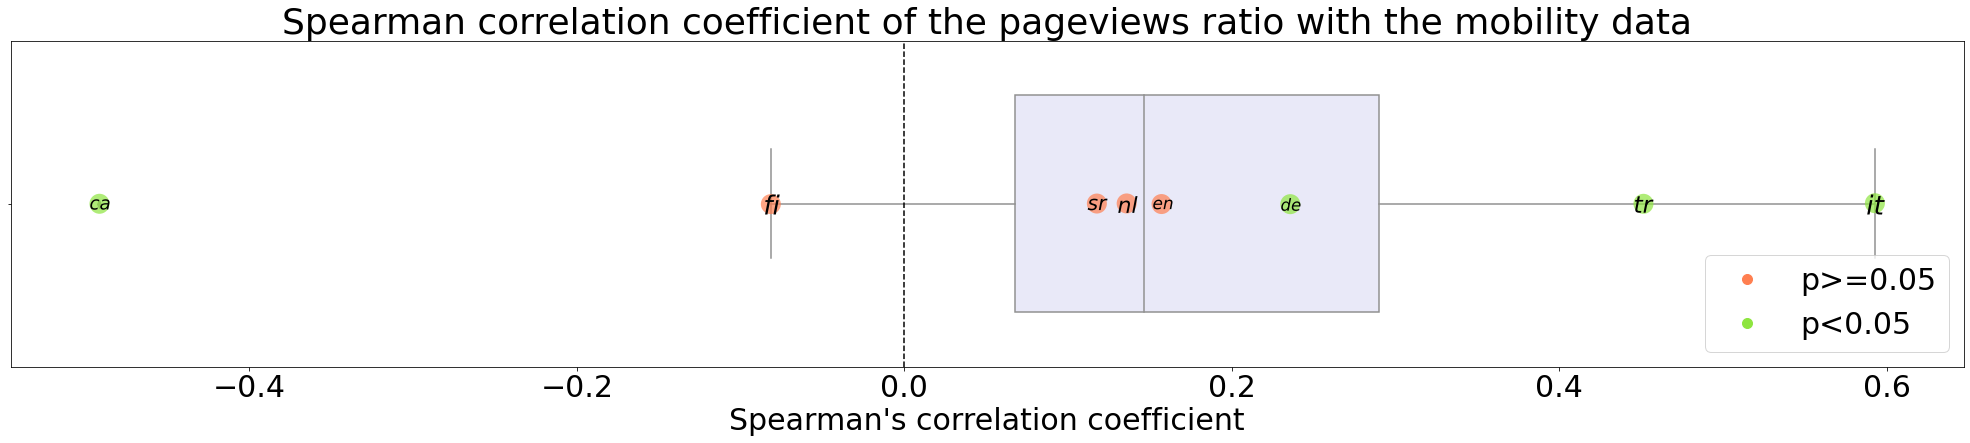

In [574]:
plot_spearman(mob_data_lan, ratio_lan, lan, None, None)

The correlation seems shifted to the right, meaning that the interest for healthy food relative to unhealthy food increased with an increase in time spent at home for most Wikipedia users. This trend is however significantly the opposite for Catalan speakers. 

We next focus our analysis to around 60 days (about 2 months) before and after major events of the pandemic timeline, to capture the influence of the changes caused by the event.

First, we study the correlation of the ratio and the mobility data about 2 months before and after the first mobility restriction.

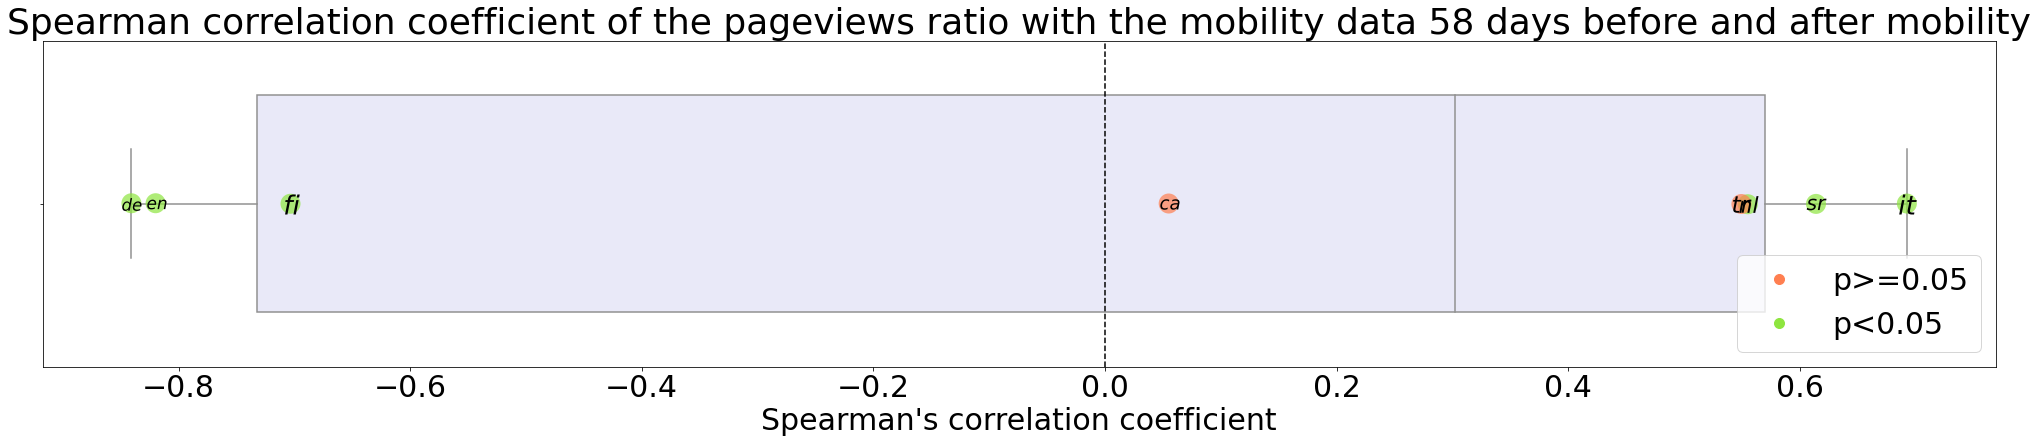

In [575]:
plot_spearman(mob_data_lan, ratio_lan, lan, 'Mobility', 58)

This time, the correlations are quite spread out, with a high negative correlation for some languages (German, English and Finnish) and a moderate positive correlation for other languages (Dutch, Serbian and Italian). This once again highlights the fact that people from different cultures reacted differently to restrictions.

Next, we analyze the correlations around the first normalcy time point.

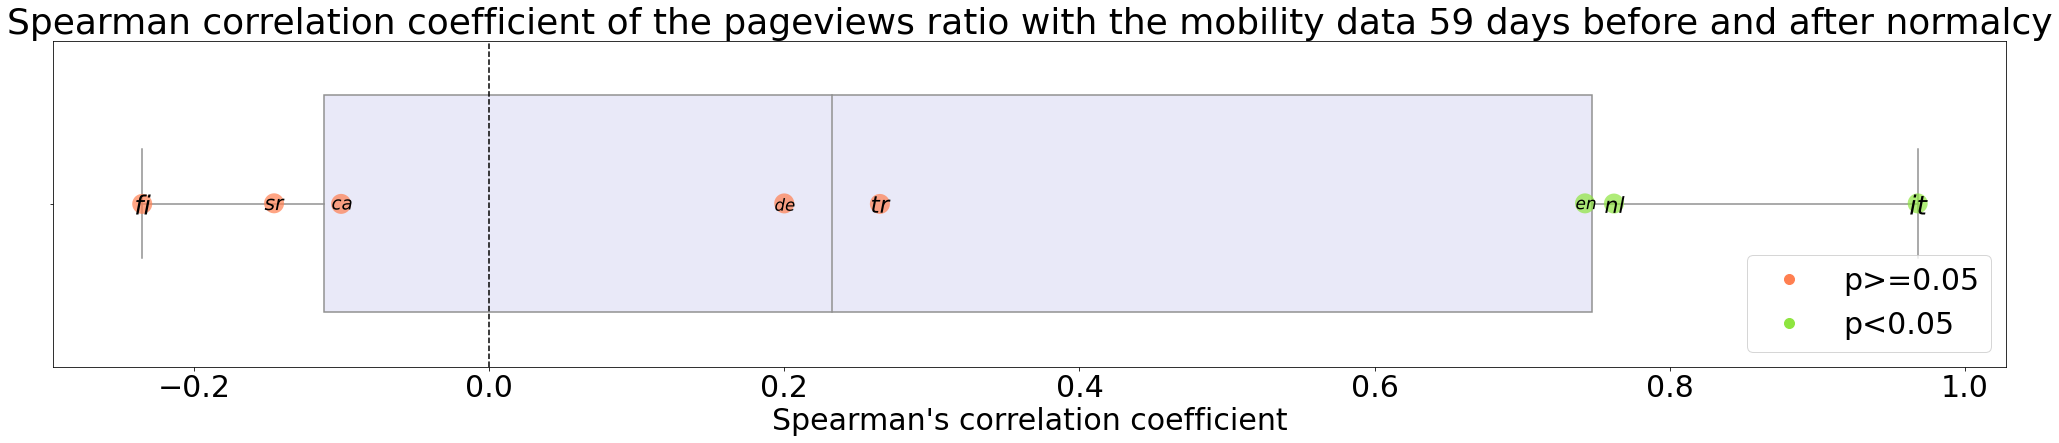

In [576]:
plot_spearman(mob_data_lan, ratio_lan, lan, 'Normalcy', 59)

The languages for which the correlation was significant had a high positive correlation: the relative interest for healthy food seemed to increase with time spent at home for English, Dutch and Italian-speaking users.

Finally, we focus on the correlations around the second normalcy time point.

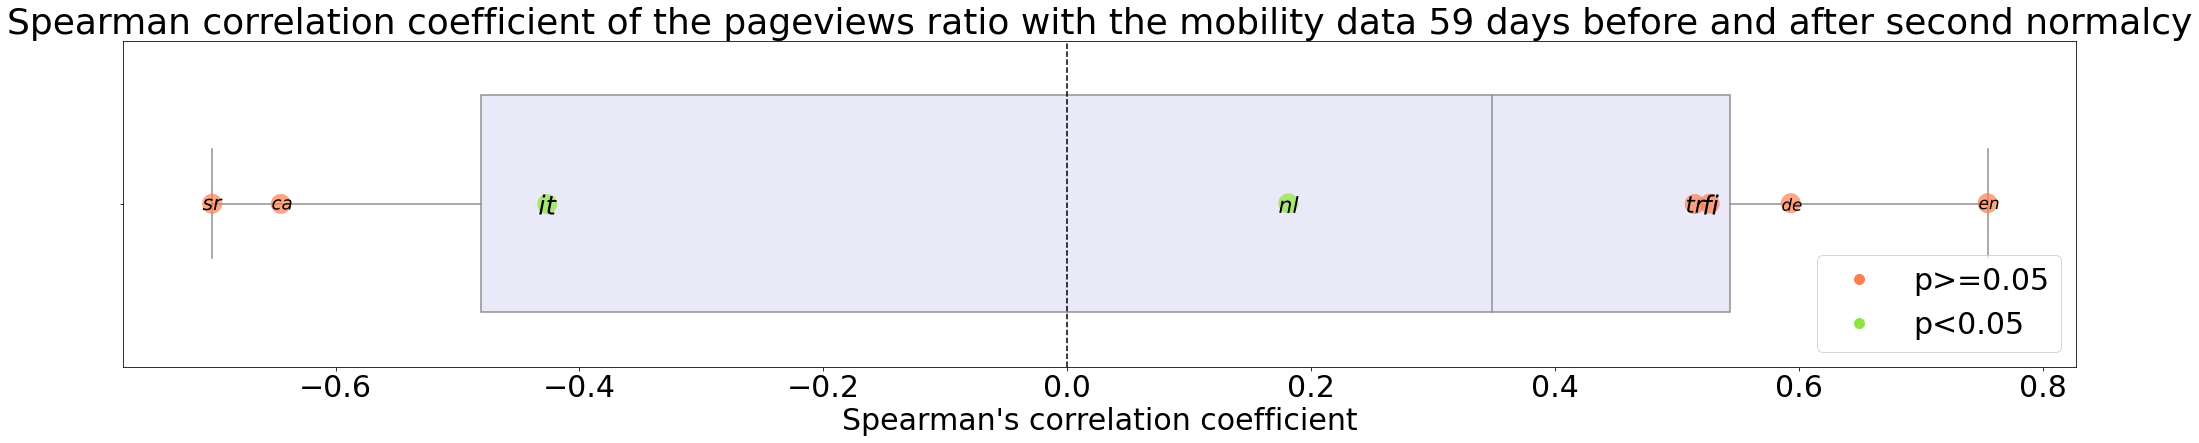

In [577]:
plot_spearman(mob_data_lan, ratio_lan, lan, 'Second_Normalcy', 59)

The correlation between interest and mobility seemed to be the opposite for Italy. Perhaps, as it was the second normalcy, the newly returned freedom influenced interests differently.  

### Conclusion

Overall, the interest seems to shift to healthy food rather than unhealthy food as the time spent at home increases. This is especially striking for Italy, where an increase in the mobility restriction was consistently associated in an increased relative interest in healthy food, although apparently not enough for healthy food to overcome unhealthy one as the ratio of pageviews between the two groups remains below 1. This positive relation between the ratio and the lockdown severity could also be observed for Serbia during the first lockdown.

This analysis revealed very interesting cultural differences on food behavior. For instance, Spain and Italy are often considered to have closely related cultures. Yet in this study, we found that the relation between healthy food interest and mobility restriction is the opposite for these two countries. Indeed, the relative interest for healthy food for Catalan speakers seemed to increase in periods when they spent less time at home. Furthermore, their interest for healthy food seems to beat the one for unhealthy food as the ratio for Spain is over 1. We notice that in Spain and Italy, the relative interest for the preferred type of food decreases during the most severe periods of lockdown. This suggests that, at least in these countries, these periods disturb people's food consumption habits instead of reinforcing their existing ones.

These results could be investigated in further studies, to find the factors that can influence differently food preferences in periods of great changes.